# New Section

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import matplotlib.patches as patches

In [3]:
from tensorflow.keras.applications.vgg16 import  VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from PIL import Image
from tensorflow.keras.layers import Dense,Reshape,Conv2D,Flatten,Dropout,Input,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow import py_function
import tensorflow 
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Load  trainig images samples
X_image_train_temp  = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/preocessed_training_images/Channel_1/X_image_train_concat_final_10k.npy')

In [5]:
# Load  testing images samples
X_image_test_temp = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/preocessed_training_images/Channel_1/X_image_test_2K.npy')

In [6]:
image_size = 224

In [7]:
# Here, we are using VGG16 model
# And using input shape (224,224,3) 3 channels.
# And using 'imagenet weights'. 
# This is the basic classification model.
def createModel(trainBaseModel=True):
    inputShape = (image_size,image_size,3)

    basemodel = VGG16(include_top=False,input_shape=inputShape,weights='imagenet')
    
    for layer in basemodel.layers:
        layer.trainable = trainBaseModel
    
    basemodel_output =  basemodel.get_layer('block5_conv3').output

    # flat_reg = Flatten()(basemodel_output)
    # dense = Dense(512,activation='relu',name='MJ_1_layer_reg')(flat_reg)
    # drop = Dropout(0.2)(dense)
    # output_reg = Dense(4,activation='linear',name='output_reg')(drop)
    
    flat_class = Flatten()(basemodel_output)
    dense = Dense(512,activation='relu',name='MJ_1_layer_dense')(flat_class)
    drop = Dropout(0.2)(dense)
    output_class = Dense(2,activation='softmax',name='output_class')(drop)
    
    return Model(inputs=basemodel.input, outputs=[output_class])

In [8]:
model = createModel(False)

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

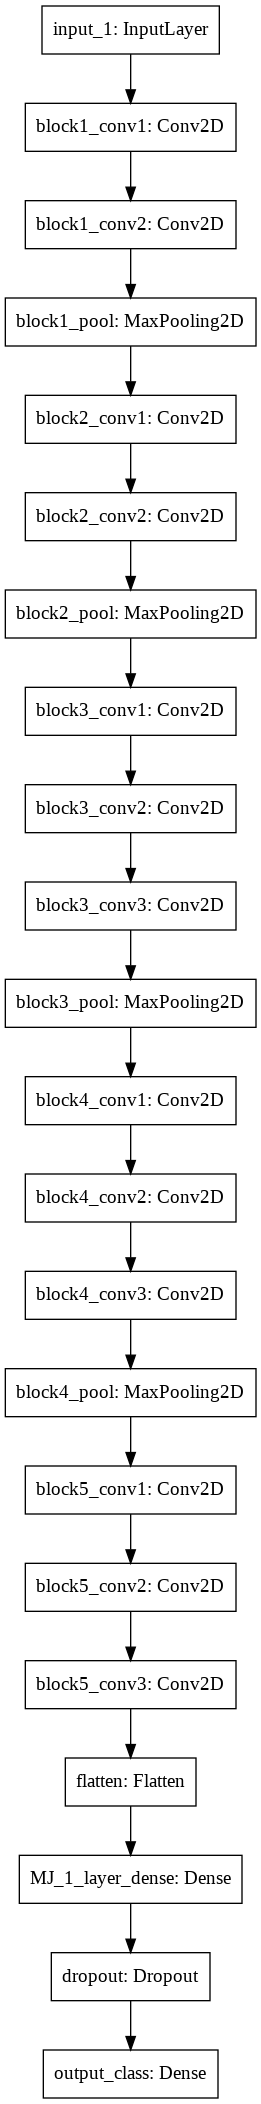

In [10]:
plot_model(model,'/model.png')

In [11]:
# Load test target values
y_target_test = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/test_input_numpy/y_target_train.npy')[0:2000]
# y_box_test = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/test_input_numpy/y_box_train.npy')[0:2000]

In [15]:
# Load train target values
y_target_train = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/y_target_train.npy')[0:10000]
y_box_train = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/y_box_train.npy')[0:10000]

In [16]:
X_train_images = np.load('/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/X_train.npy')

/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/stage_2_train_images_png/03e9a70f-3de8-4e13-b3f2-9dd6d75f496d.png
[50.75       73.11627907 26.25       44.65116279]
232 352 334 538


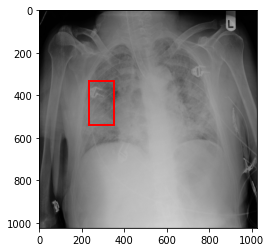

In [17]:
path = X_train_images[200]
print(path)
regions = y_box_train[200]
print(regions)
img =  cv2.imread(path)
# Image.open(path)
image_height,image_width,_ = img.shape

x1 = int(regions[0] * image_width/image_size)
y1 = int(regions[1] * image_height/image_size)

x2= int((regions[0] + regions[2])  * image_width/image_size)
y2 = int((regions[1] + regions[3]) * image_height/image_size)
print(x1,x2,y1,y2)
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='r',facecolor='none',linestyle='-', linewidth=2)
ax.add_patch(rect)

In [18]:
# Make target values to categorical type both training and testing.
y_target_test = tf.keras.utils.to_categorical(y_target_test,num_classes=2)

In [19]:
y_target_train = tf.keras.utils.to_categorical(y_target_train,num_classes=2)

In [ ]:
# define ou loss funtion
# def iou_loss(y_true,y_pred):
#   y_true = tf.reshape(y_true,[-1])
#   y_pred = tf.reshape(y_pred,[-1])
#   intersection = tf.reduce_sum(y_true * y_pred)
#   score = (intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.0)
#   return 1 - score

In [ ]:
# def iou_bce_loss(y_true,y_pred):
#   return 0.5* tensorflow.keras.losses.categorical_crossentropy(y_true,y_pred) + 0.5 * iou_loss(y_true,y_pred)

In [20]:
# Use earlystcheckpoint
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq='epoch')

# Use earlystopping
stop = EarlyStopping(patience=2, mode="min",min_delta=0.01,monitor='output_class_loss' ) #monitor, on which base you want to stop by deafult val_loss

In [27]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy") # Regression loss is MSE

# Fit the model
history = model.fit(X_image_train_temp,y_target_train, epochs=20, batch_size=128,callbacks=[stop]) #validation_data=(X_image_test_temp,[y_box_test,y_target_test])callbacks=[stop]

Epoch 1/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0657 - accuracy: 0.9767
Epoch 2/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0636 - accuracy: 0.9790
Epoch 3/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0499 - accuracy: 0.9819
Epoch 4/20
79/79 [==============================] - 19s 242ms/step - loss: 0.0596 - accuracy: 0.9800
Epoch 5/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0456 - accuracy: 0.9833
Epoch 6/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0330 - accuracy: 0.9878
Epoch 7/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0284 - accuracy: 0.9894
Epoch 8/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0477 - accuracy: 0.9832
Epoch 9/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0310 - accuracy: 0.9891
Epoch 10/20
79/79 [==============================] - 19s 241ms/step - loss: 0.0787 - accura

In [28]:
# Evaluate model
model.evaluate(X_image_test_temp,y_target_test)

63/63 [==============================] - 4s 63ms/step - loss: 1.4054 - accuracy: 0.7995


[1.4053908586502075, 0.7994999885559082]

In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/preocessed_training_images/Channel_1/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/My Drive/AIML/Capstone/Pneumonia_Detection/preocessed_training_images/Channel_1/model.h5")
print("Saved model to disk")

Saved model to disk


**Testing**

In [30]:
pip install  pydicom

     |████████████████████████████████| 1.9MB 8.6MB/s 


In [34]:
import os
import pydicom

In [35]:
# define prediction function for predicting bounding boxes and classes.
def preditction(imagename):
    imageFolderPath = "/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng"

    filepath = os.path.join(imageFolderPath,imagename)
    unscaled = cv2.imread(filepath)
    image_height, image_width, _ = unscaled.shape
    image = cv2.resize(unscaled, (image_size, image_size)) # Rescaled image to run the network
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

    result = model.predict(x=np.array([feat_scaled]))
    # region = result[0][0]
    # class_result = np.argmax(result[1][0])
    print(f'Class is : {result}')
    # x1 = int(region[0] * image_width/image_size)
    # y1 = int(region[1] * image_height/image_size)
    # x2= int((region[0] + region[2])  * image_width/image_size)
    # y2 = int((region[1] + region[3]) * image_height/image_size)

    # fig, ax = plt.subplots(1)
    # ax.imshow(unscaled)
    # rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='r',facecolor='none',linestyle='-', linewidth=2)
    # ax.add_patch(rect)


In [36]:
# VGG16 testing
source_folder_path = "/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng"
files = os.listdir(source_folder_path)
for index in range(20,30):
  file = files[index]
  imagPath = os.path.join(source_folder_path,file)
  print(imagPath)
  preditction(imagPath)

/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265dd221-9049-4bca-b5c0-4118dafa55c5.png
Class is : [[0.99733835 0.00266162]]
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265ef9f1-3a21-4c9e-a8fe-740d8fae99f5.png
Class is : [[9.9999988e-01 1.5446045e-07]]
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265f1a4a-fee4-447e-9709-0fff15f2255b.png
Class is : [[9.999684e-01 3.156404e-05]]
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/265fc72c-f5f5-41bb-ac15-7ced161736df.png
Class is : [[9.9992275e-01 7.7258235e-05]]
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/26636455-c98d-49a1-8b48-7025f535f982.png
Class is : [[9.9999750e-01 2.4779479e-06]]
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/2664366f-4f04-49e1-ab20-19b9173f23bc.png
Class is : [[0.32920593 0.670794  ]]
/content/gdrive/MyDrive/AIML/Capstone/Pneumonia_Detection/liveTestPng/266490ca-ce52-4f5b-9

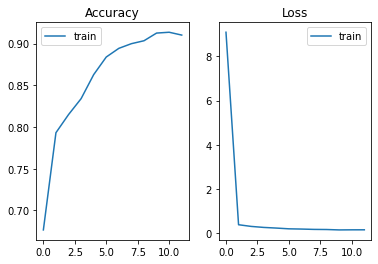

In [ ]:
fig,ax = plt.subplots(1,2)
ax[0].set_title('Accuracy')
ax[0].plot(history.history['output_class_accuracy'],label='train')
# ax[0].plot(history.history['val_accuracy'],label='test')
ax[0].legend()

ax[1].set_title('Loss')
ax[1].plot(history.history['output_class_loss'],label='train')
# ax[1].plot(history.history['val_loss'],label='test')
ax[1].legend()
# By checking the accuracy and loss plots, suggest that the model has good fit on the problem.